In [17]:
%load_ext autoreload
%autoreload 2

# How to make a dataset

In [839]:
import hashlib

import json

from collections import Counter
from pathlib import Path
from itertools import chain

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from SourceCodeTools.nlp import create_tokenizer

from SourceCodeTools.code.data.file_utils import unpersist

dataset_path = "/Users/LTV/Documents/popular_packages/graph"
envs_path = "/Users/LTV/Documents/popular_packages/envs/envs"

In [19]:
all_annotations = []
all_returned = []

for dir in Path(envs_path).iterdir():
    if not dir.is_dir() or dir.name[0] in {".", "_"}:
        continue

    nodes_path = dir.joinpath("nodes_with_ast.bz2")
    edges_path = dir.joinpath("edges_with_ast.bz2")

    if not nodes_path.is_file() or not edges_path.is_file():
        continue

    nodes = unpersist(nodes_path).rename({"serialized_name": "name"}, axis=1)
    edges = unpersist(edges_path).rename({"source_node_id": "src", "target_node_id": "dst"}, axis=1)
    node2name = dict(zip(nodes["id"], nodes["name"]))
    anns = edges.query("type == 'annotation_for'")
    rets = edges.query("type == 'returned_by'")

    all_annotations.extend(map(node2name.get, anns["src"]))
    all_returned.extend(map(node2name.get, rets["src"]))

In [44]:
def normalize_type(type_string):
    return type_string.replace(" ", "").replace("\"", "").replace("\'", "").replace(",]", "]")

tp.ClassVar[tp.Dict[str,tp.Callable[,"Tool"]]] != tp.ClassVar[tp.Dict[str,tp.Callable[[],"Tool"]]]
tp.Callable[,"Tool"] != tp.Callable[[],"Tool"]
"Optional[WebDriver] != "Optional[WebDriver]"
"Optional[WebDriver] != "Optional[WebDriver]"
"Optional[WebDriver] != "Optional[WebDriver]"
"Optional[WebDriver] != "Optional[WebDriver]"
"PathLike[AnyStr] != "PathLike[AnyStr]"
"PathLike[AnyStr] != "PathLike[AnyStr]"
"PathLike[AnyStr] != "PathLike[AnyStr]"
Callable[,None] != Callable[[],None]
Callable[...,"Generator[Any,Any,_T],"] != Callable[...,"Generator[Any,Any,_T]"]
"Union[Type[Exception],Tuple[Type[Exception],...]] != "Union[Type[Exception],Tuple[Type[Exception],...]]"
"Union[Type[Exception],Tuple[Type[Exception],...]] != "Union[Type[Exception],Tuple[Type[Exception],...]]"


## Read data

In [814]:
def read_labels_from_json(path):
    def _compute_text_id(text):
        return abs(int(hashlib.md5(text.encode('utf-8')).hexdigest(), 16)) % 1152921504606846976

    all_labels = []
    with open(path, "r") as source:
        for line in source:
            data = json.loads(line)
            text_id = _compute_text_id(data[0])
            for _, _, e in data[1]["entities"]:
                if e != "":
                    all_labels.append((text_id, e.strip().strip()))
            # print(data[1]["entities"])
            # break
    return all_labels

records_id_labels = read_labels_from_json("type_pred_data.json")
print(f"Read {len(records_id_labels)} annotations")

Read 159054 annotations


## Look through labels


In [815]:
# def read_label_examples(path):
#     unique_annotations = []
#     with open(path, "r") as source:
#         for line in source:
#             unique_annotations.append(line.strip())
#
#     return unique_annotations
#
# # annotations = read_label_examples("unique_annotations.txt")
# annotations = read_label_examples("annotations.txt")

In [817]:
# def show_by_frequency(types, stop_at):
#     for v, c in Counter(types).most_common():
#         if c > stop_at:
#             print(v, c)
#
# show_by_frequency(map(lambda x: x[1], records_id_labels), 100)

Things to look for:
1. Incorrect grammar
    - Number of opening and closing brackets do not match
    - NUmber of quatation marks is odd
2. Inconsistent format
    - spaces
    - does not start with text
    - use of quotation marks
    - type definition depth
    - weird format
    - type aliases
3. Labels that make no sense
    - one or two letter names
    - unexpected characters
    - ambiguous types

Examples of inconsistent format:
- Inconsistent use of spaces and commas (Remove spaces, remove commas if followed by bracket)
    - Union[Callable[..., None],Callable[[Callable[..., Union[Generator, "Coroutine"]]], Callable[..., None]],]
- Inconsistent type definition depth (Use only top level type)
    - Future[_T] and futures.Future[_T]]
- Inconsistent use of ellipsis (Replace ellipsis with empy space)
    - Union[Type[Exception], Tuple[Type[Exception], ...]]
    - "partial[Callable[[], None]]"
- Quotation marks (remove all quotation marks)
    - Awaitable["HTTPResponse"] and Awaitable[HTTPResponse]
- Inconsistent format (Drop)
    - (Tensor,DcmDataset)
    - float | ndarray
    - dict or str
    - Image,TensorBBox,TensorPoint
    - float | ndarray
- Inconsistent type names (keep as is)
    - str Str
    - int Int
    - dict Dict
    - set Set
    - float Float
    - tuple Tuple
    - bool Bool
- Inconsistent use of Optional (keep as is)
    - Union[None, Iterable, Callable]
- Type aliases (Use only top level type)
    - tp.Callable[[], "Tool"]
- Weird format (Drop)
    - type(object)


Examples of labels that make no sense:
- Short names (Drop)
    - 'K', 'ZZ', '_T', 'D', 'io', '_M', 'TT', 'U', 'M', 'Q', '_F', '_E', 'BV', 'E', 'If', 'W', 'T', 'F', 'kb', 'V', 'IO', 'C', 'S', 'ET'
- Unexpected characters (Drop)
    - N*d
    - <Pandas Data Frame object>
    - arg(type=StreamOptions)
- Ambiguous types (Drop)
    - Optional[Any] # maybe even makes sense but it is hard even for human to assign this label
    - Any
    - Optional
    - object

Examples:
- Union[Future[_T], concurrent.futures.Future[_T]]
- Union[Type[Exception], Tuple[Type[Exception], ...]]
- "WSGIAppType"
- "Tuple[List[Block], Index]"
- "partial[Callable[[], None]]"
- Awaitable["HTTPResponse"]'
- Callable[[Any, Any], Any] and Callable[[Any, Any], bool]
- F, IO, T, V, _KT, _S, _VT, V
- Iterable[_Node] and Iterable[Node]
- Matcher[K]
- Optional[Any]
- Union[None, Iterable, Callable]
- Union[None,bool,BaseException,Tuple["Optional[Type[BaseException]]",Optional[BaseException],Optional[TracebackType],],]
- Union[Callable[..., None],Callable[[Callable[..., Union[Generator, "Coroutine"]]], Callable[..., None]],] spaces
- tp.Callable[[], "Tool"]
- str, String, Str
- dict, Dict
- bool, Bool
- set, Set
- list, List
- type, Type
- Bytes, bytes
- Int int
- Float float
- Tuple tuple
- string String
- object, Any, Optional
- Callable[[], None] Callable[..., None]
- Tuple[int, ...]
- (Tensor,DcmDataset)
- N*d
- float | ndarray
- arg(type=StreamOptions)
- type(object)
- <Pandas Data Frame object>
- \| ( * ) * { } + - / \ = ? < >
- {'K', 'ZZ', '_T', 'D', 'io', '_M', 'TT', 'U', 'M', 'Q', '_F', '_E', 'BV', 'E', 'If', 'W', 'T', 'F', 'kb', 'V', 'IO', 'C', 'S', 'ET'} some may be even make sense

## Remove invalid records

In [ ]:
def select_labels(labels, select_fn):
    return [label for label in labels if select_fn(label)]

In [825]:
import nltk
tokenizer = nltk.RegexpTokenizer("[\w\.]+")

def type_is_valid(type):
    return (
        ("\n" not in type) and
        ("(" not in type) and
        (")" not in type) and
        ("|" not in type) and
        ("*" not in type) and
        ("<" not in type) and
        (">" not in type) and
        # (" or " not in type) and
        (len(type) > 2) and
        (type.count("[") == type.count("]")) and
        (type.count("\"") % 2 == 0) and
        (type.count("\'") % 2 == 0) and
        (type != "Optional[Any]") and
        (type != "Any") and
        (type != "Optional") and
        (type != "object") and
        (not ("," in type and "[" not in type)) and
        (not ("[" not in type and len(tokenizer.tokenize(type)) > 1))
    )

In [819]:
sorted(list(set(select_labels(map(lambda x: x[1], records_id_labels), lambda lbl: not type_is_valid(lbl)))))
# a = sorted(list(set(select_labels(map(lambda x: x[1], csn_records), lambda lbl: not type_is_valid(lbl)))))

['(QtmacsApplet, str)',
 '(Tensor,DcmDataset)',
 '(TensorImage,TensorMask,TensorPoint,TensorBBox)',
 '(str, "Market")',
 '(str, None)',
 '<Pandas Data Frame object>',
 'Any',
 'BV',
 'C',
 'D',
 'DataFrame)',
 'E',
 'ET',
 'F',
 'IO',
 'If',
 'Image,TensorBBox,TensorPoint)',
 'K',
 'M',
 'N*d',
 'Optional',
 'POINTER(pci_access))',
 'Q',
 'S',
 'T',
 'TT',
 'U',
 'V',
 'W',
 'ZZ',
 '_E',
 '_F',
 '_M',
 '_T',
 'arg(type=StreamOptions)',
 'c_char_p)',
 'c_int)',
 'dict or str',
 'django query',
 'float | ndarray',
 'int or str',
 'io',
 'kb',
 'object',
 'type(object)']

In [823]:
records_id_labels_no_invalid = list(filter(lambda x: type_is_valid(x[1]), records_id_labels))

print(f"{len(records_id_labels)} records before")
print(f"{len(records_id_labels_no_invalid)} records after")
print(f"{len(records_id_labels) - len(records_id_labels_no_invalid)} invalid records removed")

159054 records before
135142 records after
23912 invalid records removed


## Type parser definition

In [807]:
class TypeHierarchy:
    def __init__(self, type_, normalize=True, tokenize_fn=None):
        self._tokenize_fn = tokenize_fn
        if self._tokenize_fn is None:
            self._tokenize_fn = create_tokenizer("spacy")
        if normalize:
            type_ = self.normalize(type_)
        self._parse_type(type_)

    def _make_node(self, start, end):
        if end is None:
            name = "".join(t.text for t in self._tokens[start:])
        else:
            name = "".join(t.text for t in self._tokens[start:end])
        return {
            "name": name,
            "children": []
        }

    def _parse_type(self, type_string):

        self._tokens = self._tokenize_fn(type_string)

        entry_point = []
        reference_stack = [entry_point]

        start = 0

        for ind, tok in enumerate(self._tokens):
            if tok.text in {"["}:
                new_record = self._make_node(start=start, end=ind)
                reference_stack[-1].append(new_record)
                reference_stack.append(new_record["children"])
                start = ind + 1
            elif tok.text in {"]"}:
                if start != ind:# or (start > 0 and self._tokens[start-1].text == ","):
                    reference_stack[-1].append(self._make_node(start=start, end=ind))
                reference_stack.pop(-1)
                start = ind + 1
            elif tok.text in {","}:
                if start != ind or (start > 0 and self._tokens[start-1].text == "["):
                    reference_stack[-1].append(self._make_node(start=start, end=ind))
                start = ind + 1
            elif ind == len(self._tokens) - 1:
                reference_stack[-1].append(self._make_node(start=start, end=None))
                reference_stack.pop(-1)

        if len(entry_point) == 0:
            raise Exception(f"Error parsing: {self._tokens}")
        self._structure = entry_point[0]
        if len(entry_point) == 1:
            pass
        elif len(entry_point) == 2:
            self._structure["end"] = entry_point[1]["name"]
        else:
            raise Exception(f"Error parsing: {self._tokens}")

    def assemble(self, structure=None, current_level=0, max_level=-1, simplify_nodes=False):

        assert max_level != 0, "Max level can be -1 or > 0"
        if max_level != -1 and current_level == max_level:
            return ""

        if structure is None:
            structure = self._structure

        name = structure["name"]
        if simplify_nodes and not (name.startswith("\"") or name.startswith("\'") or name.startswith('"""')):
            s = name.split(".")[-1]
        else:
            s = name

        n_chld = len(structure["children"])

        if max_level != -1 and current_level < max_level - 1 and n_chld > 0 or \
            max_level == - 1 and n_chld > 0:
            s += "["
            for ind, c in enumerate(structure["children"]):
                s += self.assemble(c, current_level=current_level+1, max_level=max_level, simplify_nodes=simplify_nodes)
                if ind != n_chld - 1:
                    s += ","
            s += "]"

        if "end" in structure:
            s += structure["end"]

        return s

    def __str__(self):
        return self.assemble(self._structure)

    @staticmethod
    def normalize(type):
        return type.replace(" ", "")\
            .replace("[]", "")\
            .replace("[,]", "")\
            .replace("\"", "")\
            .replace("\'", "")\
            .replace("...", "")\
            .replace(",]", "]")\
            .replace("[,", "[")
            # .replace(',",', '",')\
            # .replace(',"]', '"]')

## Test type parser

In [826]:
def test_type_hierarchy_parser(types, normalize_types=True):
    tokenize_fn = create_tokenizer("spacy")

    mistakes = set()
    for type_ in types:
        if normalize_types is True:
            type_ = TypeHierarchy.normalize(type_)
        recovered = TypeHierarchy(type_, normalize=False, tokenize_fn=tokenize_fn).assemble()
        if recovered != type_:
            print(f"{recovered} != {type_}")
            mistakes.add(type_)

    print("Found mistakes:", len(mistakes))

In [828]:
test_type_hierarchy_parser(set(map(lambda x: x[1], records_id_labels_no_invalid)), normalize_types=True)

Found mistakes: 0


## Remove infrequent types

In [836]:
def analyze_by_frequency(types, max_level, cutoff_count=20, simplify_nodes=True, show_some_types=True):
    tokenize_fn = create_tokenizer("spacy")
    cou = Counter(map(lambda type_: TypeHierarchy(type_, tokenize_fn=tokenize_fn).assemble(simplify_nodes=simplify_nodes, max_level=max_level), types))

    frequent_types = []
    infrequent_types = []

    cutoff_found = False
    stopped_at = len(cou)

    for ind, (v, c) in enumerate(cou.most_common()):
        if c >= cutoff_count:
            frequent_types.append(v)
        else:
            if cutoff_found is False:
                cutoff_found = True
                stopped_at = ind
            infrequent_types.append(v)

    if show_some_types:
        for ind, (v, c) in enumerate(cou.most_common()):
            if ind < min(10, stopped_at - 10):
                print(c,v)
            elif ind == min(10, stopped_at - 10):
                print("...")
            elif ind > stopped_at - 10 and ind < stopped_at:
                print(c,v)

    examples_left = sum(cou[fr] for fr in frequent_types)
    examples_total = len(types)
    lost = (examples_total - examples_left) / examples_total * 100

    print("Labels with sufficient count", len(frequent_types))
    print("Labels with insufficient count", len(infrequent_types))
    print("Total examples after filtration by frequency:", examples_left)
    print(f"{lost:.2f}% of all examples is lost")

    return frequent_types, infrequent_types, examples_left

# frequent_types, infrequent_types = analyze_by_frequency(list(map(lambda x: x[1], records_id_labels_no_invalid)), 4, simplify_nodes=False, show_some_types=False)

In [853]:
data = []
level_grid = [1, 2, 3, 4]
cutoff_grid = [10, 20, 50, 100]

for n in cutoff_grid:
    data.append([])
    for i in level_grid:
        print("Cutoff at", n)
        print("Max type level:", i)
        csn_labels_frequent, csn_labels_infrequent, examples_left = analyze_by_frequency(
            list(map(lambda x: x[1], records_id_labels_no_invalid)), max_level=i, simplify_nodes=False, show_some_types=False, cutoff_count=n
        )
        data[-1].append(examples_left)
        print("\n\n")

Cutoff at 10
Max type level: 1
Labels with sufficient count 757
Labels with insufficient count 2138
Total examples after filtration by frequency: 125450
7.17% of all examples is lost



Cutoff at 10
Max type level: 2
Labels with sufficient count 757
Labels with insufficient count 2138
Total examples after filtration by frequency: 125450
7.17% of all examples is lost



Cutoff at 10
Max type level: 3
Labels with sufficient count 757
Labels with insufficient count 2138
Total examples after filtration by frequency: 125450
7.17% of all examples is lost



Cutoff at 10
Max type level: 4
Labels with sufficient count 757
Labels with insufficient count 2138
Total examples after filtration by frequency: 125450
7.17% of all examples is lost



Cutoff at 20
Max type level: 1
Labels with sufficient count 393
Labels with insufficient count 2502
Total examples after filtration by frequency: 120586
10.77% of all examples is lost



Cutoff at 20
Max type level: 2
Labels with sufficient count 393
Label

In [855]:
# # setup the figure and axes
# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(111, projection='3d')
# # ax2 = fig.add_subplot(122, projection='3d')
#
# width = depth = 1
# top = list(chain(*data))
# bottom = [0] * len(top)
#
# ax1.bar3d(cutoff_grid*4, level_grid*4, bottom, width, depth, top, shade=True)
# # ax1.set_title('Shaded')
# # ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
# # ax2.set_title('Not Shaded')
#
# plt.show()

Number of labels roughly halves when increasing cutoff

In [298]:
# def filter_invalid(types, key=None):
#     tokenize_fn = create_tokenizer("spacy")
#
#     def is_valid(type_):
#         type__ = TypeHierarchy.normalize(type_)
#         recovered = TypeHierarchy(type__, normalize=False, tokenize_fn=tokenize_fn).assemble()
#         # if type_ != recovered:
#         #     print(repr(type_))
#         return type_ == recovered
#
#     def get_with_key(value):
#         if key is None:
#             return value
#         else:
#             return key(value)
#
#     filtered = []
#     invalid = []
#     for type_ in types:
#         if is_valid(get_with_key(type_)):
#             filtered.append(type_)
#         else:
#             invalid.append(type_)
#
#     print(f"{len(invalid)} types removed")
#     for inv in invalid:
#         print(inv)
#
#     print("Types after filtering:", len(filtered))
#
#     return filtered
#
# csn_records_valid = filter_invalid(csn_records, key=lambda x: x[1])

64 types removed
(156371823849564913, '<Pandas Data Frame object>')
(114573929172299839, '(str, None)')
(838457716598630301, 'float | ndarray')
(849170696852833320, '(Tensor,DcmDataset)')
(126668903805901174, '(str, None)')
(365899323198707298, 'Image,TensorBBox,TensorPoint)')
(1027684177034746755, '(str, "Market")')
(108713408353656770, '<Pandas Data Frame object>')
(189873927155695279, '(QtmacsApplet, str)')
(821447222447413906, '(TensorImage,TensorMask,TensorPoint,TensorBBox)')
(325483502150813797, 'Image,TensorBBox,TensorPoint)')
(961369755501382860, '(QtmacsApplet, str)')
(961369755501382860, '(QtmacsApplet, str)')
(721436258809799645, 'dict or str')
(1143315430196865363, 'float | ndarray')
(1143315430196865363, 'float | ndarray')
(1143315430196865363, 'float | ndarray')
(1143315430196865363, 'float | ndarray')
(326164424041008271, 'Image,TensorBBox,TensorPoint)')
(958228880565602526, 'dict or str')
(677552017924752460, '(TensorImage,TensorMask,TensorPoint,TensorBBox)')
(165965027

In [857]:
labels_frequent, labels_infrequent, _ = analyze_by_frequency(
    list(map(lambda x: x[1], records_id_labels_no_invalid)), max_level=3, simplify_nodes=False, show_some_types=False, cutoff_count=50
)

Labels with sufficient count 146
Labels with insufficient count 2749
Total examples after filtration by frequency: 113132
16.29% of all examples is lost


In [861]:
def keep_frequent(records, frequent, key=None):
    def get_with_key(value):
        if key is None:
            return value
        else:
            return key(value)

    frequent = set(frequent)
    return [r for r in records if get_with_key(r) in frequent]

records_id_labels_no_invalid_frequent = keep_frequent(records_id_labels_no_invalid, labels_frequent, key=lambda x: x[1])

## Naive partitioning scheme

In [664]:
def naive_train_test_partitioning(record_ids, frac=0.8):
    train_ids_, test_ids_ = train_test_split(record_ids, train_size=frac)
    train_ids = set(train_ids_)
    test_ids = set(test_ids_)

    assert len(train_ids) == len(train_ids_)
    assert len(test_ids) == len(test_ids_)

    assert len(train_ids.intersection(test_ids)) == 0, "Train and test sets overlap"
    return train_ids, test_ids

train_ids, test_ids = naive_train_test_partitioning(list(set(map(lambda x: x[0], records_id_labels_no_invalid_frequent))), frac=0.8)

print("Records in total:", len(train_ids) + len(test_ids))
print("Records in train:", len(train_ids))
print("Records in test:", len(test_ids))
print("Proportion:", len(train_ids) / (len(test_ids) + len(train_ids)))

Records in total: 47292
Records in train: 37833
Records in test: 9459
Proportion: 0.7999873128647551


## Visualize partition distributions

In [665]:
def get_table_from_records(records):
    table = {
        "id": [],
        "label": []
    }

    for record_id, label in records:
        table["id"].append(record_id)
        table["label"].append(label)

    return pd.DataFrame(table)

get_table_from_records(records_id_labels_no_invalid_frequent)

,id,label
0,98129767336211636,str
1,98129767336211636,str
2,927110628811075597,PeerIdentity
3,927110628811075597,Message
4,927110628811075597,Future
...,...,...
114009,688331910208579551,str
114010,688331910208579551,bool
114011,405341055275180833,Callable
114012,405341055275180833,Contract


In [666]:
def get_label_table_from_splits(records, train_ids, test_ids):

    records_table = get_table_from_records(records)

    def assign_partition(record_id):
        if record_id in train_ids:
            return "train"
        elif record_id in test_ids:
            return "test"
        else:
            raise Exception(f"Record {record_id} is neither in train nor in test sets")

    records_table["partition"] = records_table["id"].apply(assign_partition)
    return records_table

label_splits_table = get_label_table_from_splits(records_id_labels_no_invalid_frequent, train_ids, test_ids)
label_splits_table

,id,label,partition
0,98129767336211636,str,train
1,98129767336211636,str,train
2,927110628811075597,PeerIdentity,train
3,927110628811075597,Message,train
4,927110628811075597,Future,train
...,...,...,...
114009,688331910208579551,str,train
114010,688331910208579551,bool,train
114011,405341055275180833,Callable,train
114012,405341055275180833,Contract,train


In [667]:
def compute_distributions(table, categorical_column, partition_column):
    assert categorical_column in table.columns and partition_column in table.columns, "Requested columns are not in the table"
    dist_table = pd.DataFrame(table.groupby([categorical_column, partition_column])[partition_column].agg("count"))\
            .rename({partition_column: "count"}, axis=1)\
            .reset_index()\
            .pivot(index=categorical_column, columns=partition_column, values="count")\
            .fillna(0)\
            .astype("int64")
    return dist_table / dist_table.sum()

true_dist = compute_distributions(label_splits_table, categorical_column="label", partition_column="partition")
true_dist

partition,test,train
label,,
APIServer,0.000264,0.000329
AST,0.000395,0.000811
AbstractEventLoop,0.000835,0.001184
ActionDistribution,0.000395,0.000230
Address,0.000922,0.001293
...,...,...
timedelta,0.000088,0.000219
tuple,0.000615,0.000964
type,0.000791,0.001085


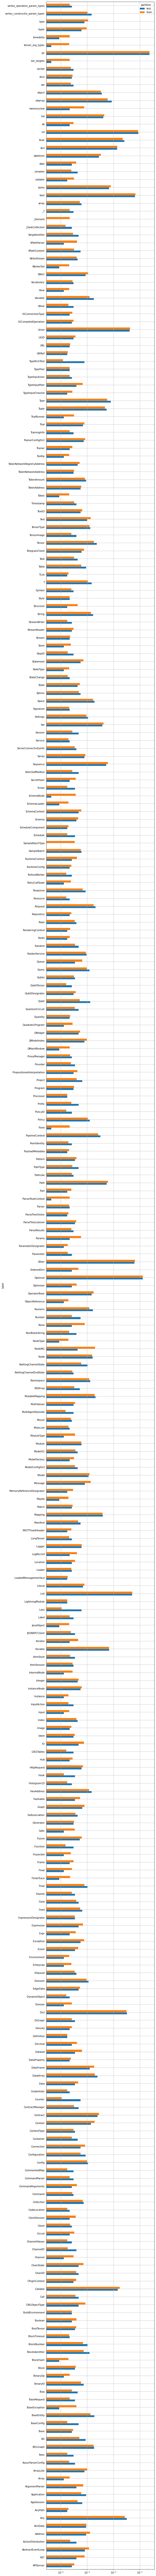

In [668]:
def plot_dist(dist_table):
    dist_table.plot.barh(figsize=(8, 0.6 * len(dist_table)))
    plt.gca().set_xscale('log')
    plt.grid()

plot_dist(true_dist)

In [669]:
plt.close("all")

## Measure distribution difference

In [670]:
def tvd(dist1, dist2):
    return 0.5*(dist1 - dist2).abs().sum()

In [671]:
def reshuffle(table, column_to_keep, column_to_reshuffle):
    reshuffled_col_name = f"shuffled {column_to_reshuffle}"
    table[reshuffled_col_name] = table[column_to_reshuffle]\
        .sample(frac=1., replace=False)\
        .tolist()
    return table[[column_to_keep, reshuffled_col_name]].rename({reshuffled_col_name: column_to_reshuffle}, axis=1)

reshuffled_dist = reshuffle(label_splits_table, column_to_keep="partition", column_to_reshuffle="label")
reshuffled_dist

,partition,label
0,train,AbstractEventLoop
1,train,Optional
2,train,str
3,train,Callable
4,train,Optional
...,...,...
114009,train,str
114010,train,int
114011,train,Optional
114012,train,Optional


In [672]:
reshuf_dist = compute_distributions(reshuffled_dist, categorical_column="label", partition_column="partition")

print("True dist diff:", tvd(true_dist["train"], true_dist["test"]))
print("Reshuf dist diff:", tvd(reshuf_dist["train"], reshuf_dist["test"]))

True dist diff: 0.03934969882449639
Reshuf dist diff: 0.0300943422551243


## Permutation test

In [673]:
def collect_two_sample_tvd_statistics(
        label_splits_table, repetitions, categorical_column, partition_column,
        first_sample_label, second_sample_label
):
    assert categorical_column in label_splits_table.columns and partition_column in label_splits_table.columns, "Requested columns are not in the table"
    assert repetitions > 2
    unique_partitions = label_splits_table[partition_column].unique()
    assert len(unique_partitions) == 2, "More than two samples provided"
    assert first_sample_label in unique_partitions and second_sample_label in unique_partitions, "Sample labels not found"

    tvds = []
    for _ in tqdm(range(repetitions), total=repetitions, desc="Resampling"):
        reshuf_dist = compute_distributions(
            reshuffle(label_splits_table, column_to_keep=partition_column, column_to_reshuffle=categorical_column),
            categorical_column=categorical_column, partition_column=partition_column
        )
        tvds.append(tvd(reshuf_dist[first_sample_label], reshuf_dist[second_sample_label]))
    return tvds

tvd_statistics = collect_two_sample_tvd_statistics(
    label_splits_table, repetitions=200, categorical_column="label", partition_column="partition",
    first_sample_label="train", second_sample_label="test"
)

Resampling: 100%|██████████| 200/200 [00:18<00:00, 11.00it/s]


Observed TVD: 0.03934969882449639
Empirical P-value: 0.0


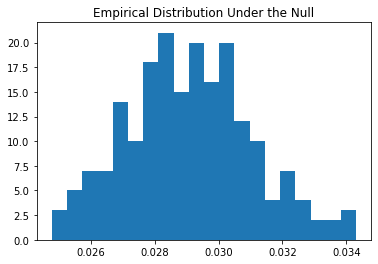

In [674]:
def compute_empirical_p_value(randomized_test_statistics, observed_test_statistics):
    return sum(value >= observed_test_statistics for value in randomized_test_statistics) / len(randomized_test_statistics)

def permutation_test_tvd(tvd_statistics, observed_tvd):
    emp_p = compute_empirical_p_value(tvd_statistics, observed_tvd)
    plt.hist(tvd_statistics, bins=20)
    plt.title('Empirical Distribution Under the Null')
    print('Observed TVD:', observed_tvd)
    print('Empirical P-value:', emp_p)

permutation_test_tvd(tvd_statistics, tvd(true_dist["train"], true_dist["test"]))

In [675]:
def perform_permutaton_test(
        label_splits_table, repetitions=10, categorical_column="label", partition_column="partition",
        first_sample_label="train", second_sample_label="test"
):
    true_dist = compute_distributions(label_splits_table, categorical_column, partition_column)
    tvd_statistics = collect_two_sample_tvd_statistics(
        label_splits_table, repetitions, categorical_column, partition_column,
        first_sample_label, second_sample_label
    )
    permutation_test_tvd(tvd_statistics, tvd(true_dist["train"], true_dist["test"]))

Resampling: 100%|██████████| 200/200 [00:18<00:00, 10.67it/s]


Observed TVD: 0.03934969882449639
Empirical P-value: 0.0


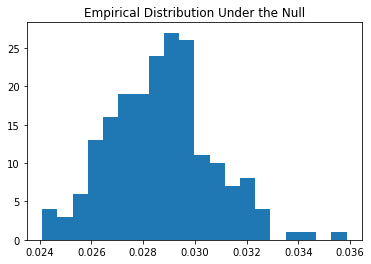

In [676]:
perform_permutaton_test(label_splits_table, repetitions=200)

## Stratified partitioning

In [677]:
def make_label_assignment_table(individual_records):
    return pd.DataFrame(get_table_from_records(individual_records)[["id", "label"]].groupby(["id", "label"])["label"].agg("count"))\
        .rename({"label": "count"}, axis=1)\
        .reset_index()\
        .pivot(index="id", columns="label", values="count")\
        .fillna(0)\
        .astype("int64")

label_assignment = make_label_assignment_table(records_id_labels_no_invalid_frequent)
label_assignment

label,APIServer,AST,AbstractEventLoop,ActionDistribution,Address,AnnData,Any,AnyPath,AppSession,Application,...,slice,socket,sos_targets,str,tensor_arg_types,timedelta,tuple,type,vertex_constructor_param_types,vertex_operation_param_types
id,,,,,,,,,,,,,,,,,,,,,
7870724039590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63076365227901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76101598662259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
84131633590577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
98560277511036,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152720636625839749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1152747442191843559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1152797102873906324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [678]:
def stratify(records, partition_column_name="partition", frac=0.8):

    unique_ids = set(map(lambda x: x[0], records))

    label_assignment_ = make_label_assignment_table(records)
    assert label_assignment_.shape[0] == len(unique_ids)
    assert partition_column_name not in label_assignment_.columns, f"Column name {partition_column_name} is in use. Choose another partition column name."

    train_ids = set()
    test_ids = set()
    target_proportion = frac

    def compute_proportion(num_total, target_proportion, in_train, not_assigned):
        # target_p = (in_train + chosen_p * unlabeled) / (unlabeled + in_train + in_test)
        # (target_p * (unlabeled + in_train + in_test) - in_train) / unlabeled
        # not_labeled = records[partition_column_name].isna().sum()
        if not_assigned == 0:
            return -1.

        # in_train = len(records.query(f"{partition_column_name} == 'train'"))
        estimated_target = min((target_proportion * num_total - in_train) / not_assigned, 1.)
        return estimated_target

    def assign_partition(table, ids, partition_name):
        table.loc[table.index.map(lambda x: x in ids).values, partition_column_name] = partition_name

    def get_entries_for_current_label(label):
        return label_assignment_.loc[label_assignment_[label] > 0, [label, partition_column_name]]

    sorted_label_count = label_assignment_.sum().sort_values()
    label_assignment_[partition_column_name] = pd.NA  # init partitions

    for ind, (label, count) in tqdm(enumerate(zip(sorted_label_count.index, sorted_label_count)), total=len(sorted_label_count), desc="Stratifying"):
        records_with_labels = get_entries_for_current_label(label)

        not_assigned = records_with_labels.query(f"{partition_column_name}.isna()")
        in_train = len(records_with_labels.query(f"{partition_column_name} == 'train'"))
        proportion_for_this_label = compute_proportion(
            num_total=len(records_with_labels), target_proportion=target_proportion, in_train=in_train,
            not_assigned=len(not_assigned)
        )

        if proportion_for_this_label == 1.:
            train_ids.update(not_assigned.index)
        elif proportion_for_this_label == 0.:
            test_ids.update(not_assigned.index)
        elif proportion_for_this_label == -1.:  # nothing to assign
            continue
        else:
            train, test = train_test_split(not_assigned, train_size=proportion_for_this_label)
            train_ids.update(train.index)
            test_ids.update(test.index)

        assign_partition(label_assignment_, train_ids, "train")
        assign_partition(label_assignment_, test_ids, "test")

    assert label_assignment_.isna().sum().sum() == 0

    return train_ids, test_ids

train_ids_stratified, test_ids_stratified = stratify(records_id_labels_no_invalid_frequent)

print("Records in total:", len(train_ids_stratified) + len(test_ids_stratified))
print("Records in train:", len(train_ids_stratified))
print("Records in test:", len(test_ids_stratified))
print("Proportion:", len(train_ids_stratified) / (len(test_ids_stratified) + len(train_ids_stratified)))

Stratifying: 100%|██████████| 325/325 [00:13<00:00, 23.75it/s]


Records in total: 47292
Records in train: 37832
Records in test: 9460
Proportion: 0.799966167639347


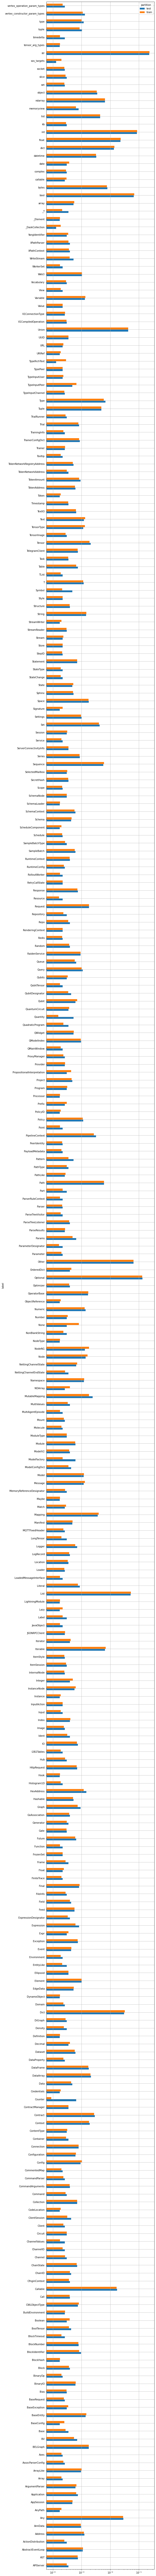

In [679]:
label_splits_stratified_table = get_label_table_from_splits(records_id_labels_no_invalid_frequent, train_ids_stratified, test_ids_stratified)
true_dist_stratified = compute_distributions(label_splits_stratified_table, categorical_column="label", partition_column="partition")
plot_dist(true_dist_stratified)

In [680]:
plt.close("all")

Resampling: 100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


Observed TVD: 0.01774562281706741
Empirical P-value: 1.0


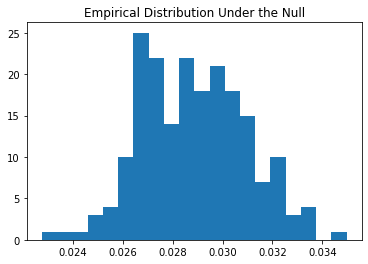

In [681]:
perform_permutaton_test(label_splits_stratified_table, repetitions=200)

## Human level performance

In [305]:
# train, test = train_test_split(csn_records_frequent, stratify=list(map(lambda x: x[1], csn_records_frequent)))
    # list(map(lambda x: x[0], csn_labels_f)),
    # list(map(lambda x: x[1], csn_labels_f))
# )#, stratify=lbls)

Train labels:  325
Test labels:  324


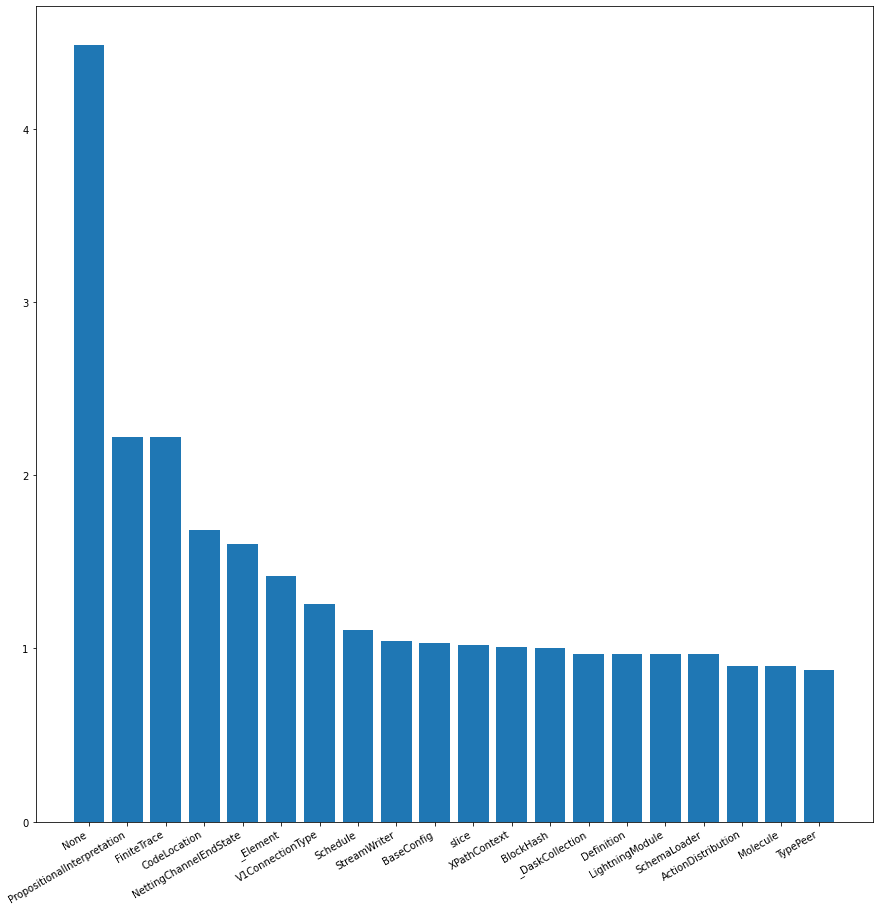

In [351]:
# def compute_distribution(records, split_ids):
#     examples = []
# 
#     for record_id, label in records:
#         # print(record_id)
#         if record_id in split_ids:
#             examples.append(label)
# 
#     counts = Counter(examples)
#     total = sum(counts.values())
# 
#     for key in counts:
#         counts[key] /= total
# 
#     return counts
# 
# train_distribution = compute_distribution(csn_records_frequent, train_ids)
# test_distribution = compute_distribution(csn_records_frequent, test_ids)
# 
# difference = Counter()
# for key in train_distribution:
#     difference[key] = abs(train_distribution[key] - test_distribution[key]) / train_distribution[key]
# 
# items_to_plot = 20
# top_difference_labels, top_difference_amounts = zip(*list(difference.most_common())[:items_to_plot])
# 
# # plt.bar(
# #     top_difference_labels,
# #     [test_distribution[key] for key in top_difference_labels]
# # )
# plt.figure(figsize=(15,15))
# plt.bar(
#     top_difference_labels,
#     top_difference_amounts
# )
# plt.xticks(rotation=30, ha='right')
# 
# 
# print("Train labels: ", len(train_distribution))
# print("Test labels: ", len(test_distribution))
# # print("Intersection: ", len(set(train_ids).intersection(set(test_ids))))